In [1]:
%matplotlib inline
from cox import readers
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

In [2]:
r = readers.CollectionReader('../src/adv_histogram/agents')

100%|██████████| 128/128 [00:12<00:00,  9.85it/s]


In [3]:
metadata = r.df('metadata')
opt = r.df('optimization')
opt['opt_step'] = opt.index
nadv = r.df('normalized_advantage')
nadv['opt_step'] = (nadv.index % 50) * 10
constraints = r.df('paper_constraints_train')
constraints_heldout = r.df('paper_constraints_heldout')

In [4]:
code_level_opts = {
      #'clip_eps': [0.2, 1e8],
      #'kl_penalty_coeff': [0.0, 0.3, 1, 3, 10],
      #'kl_penalty_direction': ['new_to_old', 'old_to_new'],
      #'clip_advantages': [2, 3, 1e8],
      'norm_rewards': ['none', 'returns'],
      #'anneal_lr': [False, True],
      'value_clipping': [False, True],
      'clip_rewards': [10.0, 1e8],
      'clip_observations': [10.0, 1e8],
      #'initialization': ['xavier', 'orthogonal']
}

In [5]:
key_metadata = metadata[['exp_id', 'game'] + list(code_level_opts.keys())]
constraints = constraints.merge(key_metadata, on='exp_id')
constraints_heldout = constraints_heldout.merge(key_metadata, on='exp_id')
nadv = nadv.merge(key_metadata, on='exp_id')
opt = opt.merge(key_metadata, on='exp_id')

In [6]:
nadv_metrics = ['kurtosis', 'skewness', 'max', 'min']

In [7]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def extract_nadv(exp_ids, min_step=0, max_step=500):
    aggregate_approx_nadv = []
    for exp_id in exp_ids:
        path = '../src/adv_histogram/agents/%s/tensorboard' % exp_id
        event_acc = EventAccumulator(path, size_guidance={
            'histograms': 0, # store everything
        })
        event_acc.Reload()
        histograms = event_acc.Histograms('normalized_advantages')
        for h in histograms:
            if h.step < min_step or h.step > max_step:
                continue
            bucket_limit = np.array(h.histogram_value.bucket_limit)
            bucket_counts = np.array(h.histogram_value.bucket).astype(np.int)
            aggregate_approx_nadv.append(np.repeat(bucket_limit, bucket_counts))
    return np.array(aggregate_approx_nadv)

def show_histogram(exp_ids, ax, label='', min_step=0, max_step=500):
    aggregate_approx_nadv = extract_nadv(exp_ids, min_step, max_step)
    sns.distplot(aggregate_approx_nadv.flatten(), ax=ax, label=label)

In [8]:
key_metadata.head()

,exp_id,game,norm_rewards,value_clipping,clip_rewards,clip_observations
0,094841c9-e2df-4378-ac56-53ea87786046,Humanoid-v2,none,True,10.0,100000000.0
0,dff0e98c-048a-4a1b-b727-76438f061821,Humanoid-v2,none,True,100000000.0,100000000.0
0,8028046b-9fc5-4df7-9a2b-6fd52b25c356,Walker2d-v2,returns,False,100000000.0,100000000.0
0,8b5172a2-1016-4a89-b5eb-0e8932a52b14,Humanoid-v2,none,False,10.0,10.0
0,9083447b-2542-4b0f-bb50-3b5ba1356523,Humanoid-v2,none,False,100000000.0,10.0


In [9]:
exp_id_lookup = key_metadata.groupby(
    ['game', 'norm_rewards'])['exp_id'].apply(list)

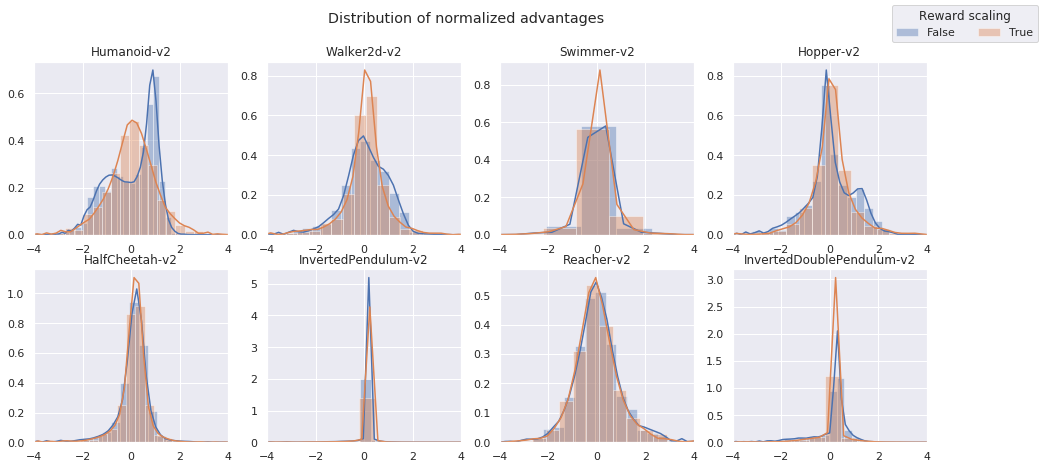

In [11]:
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
ax_idx = 0
for game in key_metadata.game.unique():
    ax = axes.flatten()[ax_idx]
    ax_idx += 1
    for rw in key_metadata.norm_rewards.unique():
        show_histogram(exp_id_lookup[game][rw], ax, label=rw, min_step=0, max_step=500)
    ax.set_title(game)
    ax.set_xlim([-4, 4])
    ax.legend()
    ax.get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.suptitle('Distribution of normalized advantages')
fig.legend(handles, ['False', 'True'], loc='upper right', title='Reward scaling', ncol=3)
plt.show()

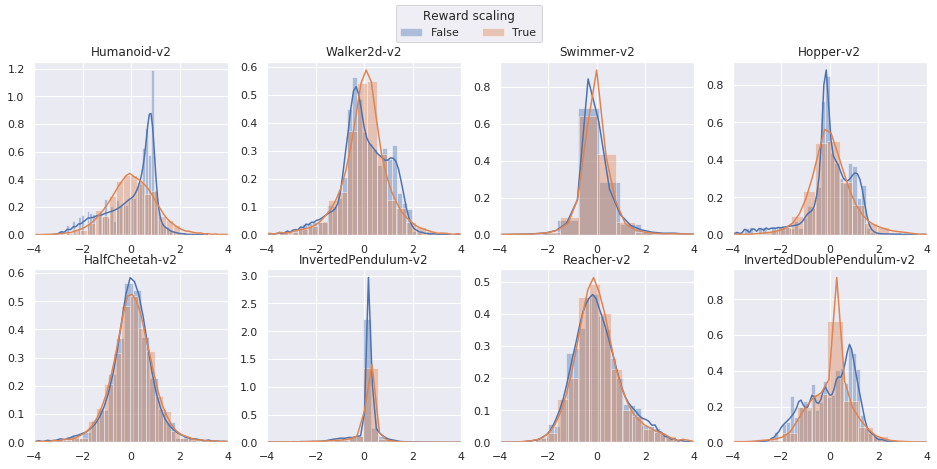

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
ax_idx = 0
for game in key_metadata.game.unique():
    ax = axes.flatten()[ax_idx]
    ax_idx += 1
    for rw in key_metadata.norm_rewards.unique():
        show_histogram(exp_id_lookup[game][rw], ax, label=rw, min_step=0, max_step=100)
    ax.set_title(game)
    ax.set_xlim([-4, 4])
    ax.legend()
    ax.get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
#fig.suptitle('Distribution of normalized advantages, training steps 0 - 100')
fig.legend(handles, ['False', 'True'], loc='upper center', title='Reward scaling', ncol=3)
plt.show()

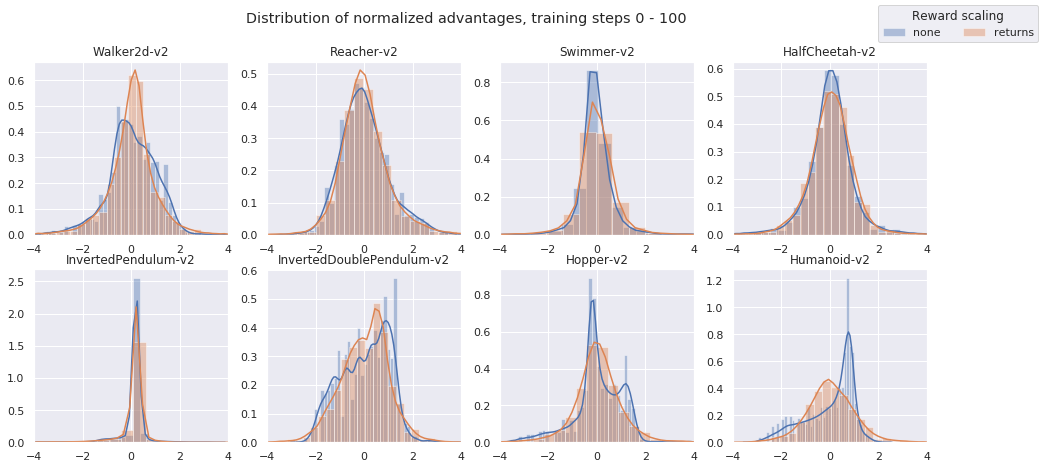

In [51]:
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
ax_idx = 0
for game in key_metadata.game.unique():
    ax = axes.flatten()[ax_idx]
    ax_idx += 1
    for rw in key_metadata.norm_rewards.unique():
        show_histogram(exp_id_lookup[game][rw], ax, label=rw, min_step=0, max_step=100)
    ax.set_title(game)
    ax.set_xlim([-4, 4])
    ax.legend()
    ax.get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.suptitle('Distribution of normalized advantages, training steps 0 - 100')
fig.legend(handles, ['False', 'True'], loc='upper right', title='Reward scaling', ncol=3)
plt.show()

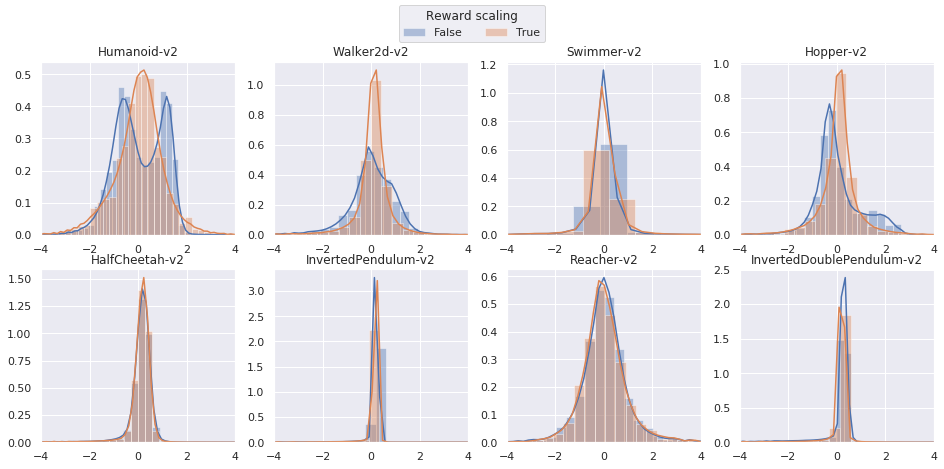

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
ax_idx = 0
for game in key_metadata.game.unique():
    ax = axes.flatten()[ax_idx]
    ax_idx += 1
    for rw in key_metadata.norm_rewards.unique():
        show_histogram(exp_id_lookup[game][rw], ax, label=rw, min_step=400, max_step=500)
    ax.set_title(game)
    ax.set_xlim([-4, 4])
    ax.legend()
    ax.get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
#fig.suptitle('Distribution of normalized advantages, training steps 400 - 500')
fig.legend(handles, ['False', 'True'], loc='upper center', title='Reward scaling', ncol=3)
plt.show()

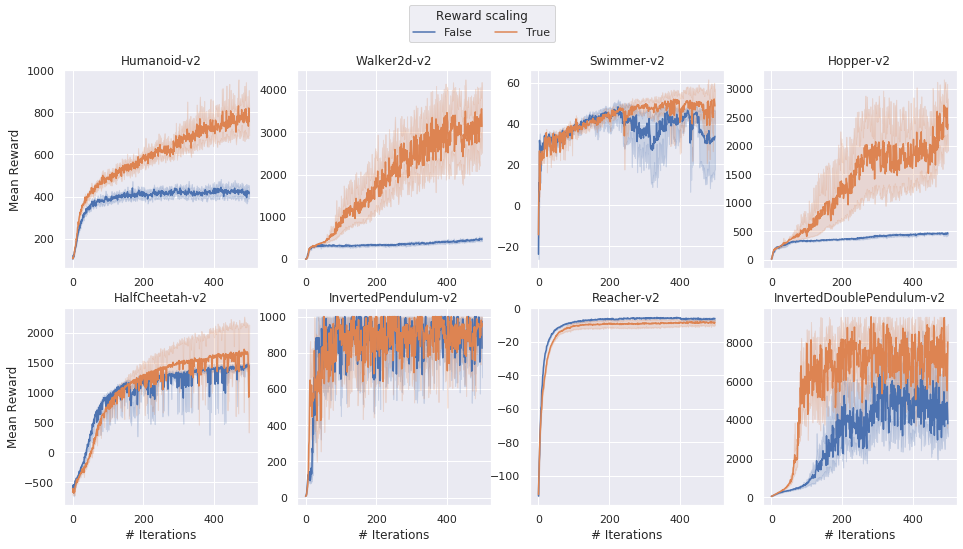

In [14]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(key_metadata.game.unique()):
    cl_opt = 'norm_rewards'
    for b in code_level_opts[cl_opt]:
        filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
        sns.lineplot(filt.opt_step, filt.mean_reward,
                     ax=ax.flatten()[j], label=b, legend=False)
    ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_ylabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, ['False', 'True'], loc='upper center', title='Reward scaling', ncol=2)

plt.show()

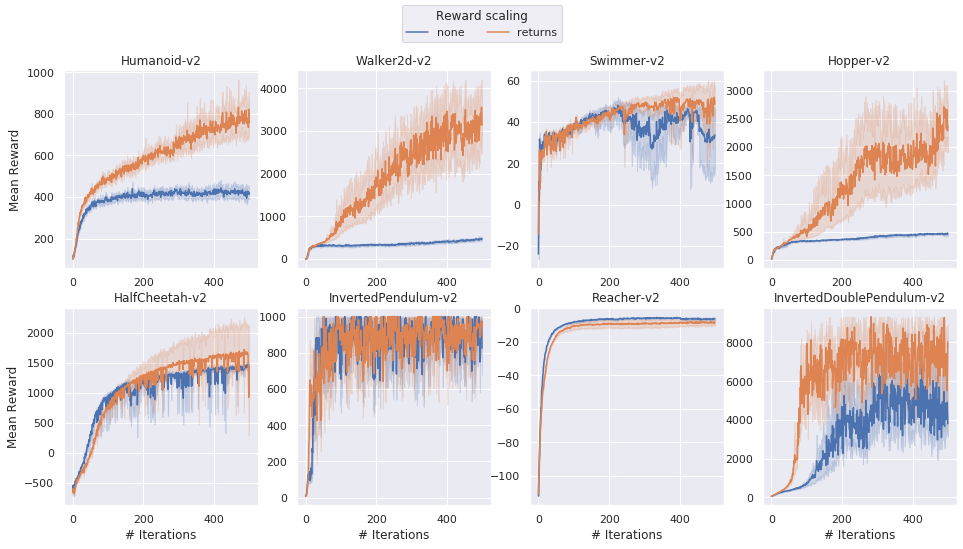

In [29]:
# Plot setup
fig, ax = plt.subplots(2, 4, figsize=(16,8))

for j, g in enumerate(key_metadata.game.unique()):
    cl_opt = 'norm_rewards'
    for b in code_level_opts[cl_opt]:
        filt = opt[(opt[cl_opt] == b) & (opt.game == g)]
        sns.lineplot(filt.opt_step, filt.mean_reward,
                     ax=ax.flatten()[j], label=b, legend=False)
    ax.flatten()[j].set_title(g)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0][0].set_ylabel('Mean Reward')
ax[1][0].set_ylabel('Mean Reward')
for a in ax[1]:
    a.set_xlabel('# Iterations')
    
handles, labels = ax[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', title='Reward scaling', ncol=2)

plt.show()

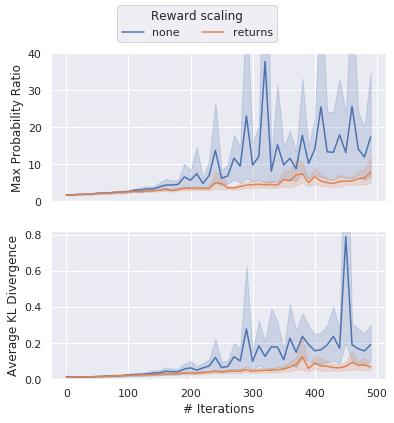

In [63]:
# Plot setup
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)

for j, m in enumerate(['max_ratio', 'avg_kl_new_to_old']):
    cl_opt = 'norm_rewards'
    for b in code_level_opts[cl_opt]:
        filt = constraints_heldout[(constraints_heldout[cl_opt] == b)]
        sns.lineplot(filt.opt_step, filt[m],
                     ax=ax.flatten()[j], label=b, legend=False)
    #ax.flatten()[j].set_title(m)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0].set_ylabel('Max Probability Ratio')
ax[1].set_ylabel('Average KL Divergence')
ax[1].set_xlabel('# Iterations')
ax[0].set_ylim([0,40])
ax[1].set_ylim([0,0.82])
    
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', title='Reward scaling', ncol=2)

plt.show()

In [67]:
nadv.tail()

,opt_step,skewness,kurtosis,max,min,exp_id,game,norm_rewards,value_clipping,clip_rewards,clip_observations
6395,450,-4.748231,30.657434,5.023105,-9.098535,64c89d8a-74e1-4a65-ae7c-34b9ab020e12,InvertedDoublePendulum-v2,returns,False,100000000.0,100000000.0
6396,460,-7.062639,58.456783,1.474019,-10.734672,64c89d8a-74e1-4a65-ae7c-34b9ab020e12,InvertedDoublePendulum-v2,returns,False,100000000.0,100000000.0
6397,470,-4.500967,26.995743,3.470052,-9.043106,64c89d8a-74e1-4a65-ae7c-34b9ab020e12,InvertedDoublePendulum-v2,returns,False,100000000.0,100000000.0
6398,480,-6.605053,54.704987,3.246833,-10.504312,64c89d8a-74e1-4a65-ae7c-34b9ab020e12,InvertedDoublePendulum-v2,returns,False,100000000.0,100000000.0
6399,490,-4.571944,41.733685,4.549911,-11.238706,64c89d8a-74e1-4a65-ae7c-34b9ab020e12,InvertedDoublePendulum-v2,returns,False,100000000.0,100000000.0


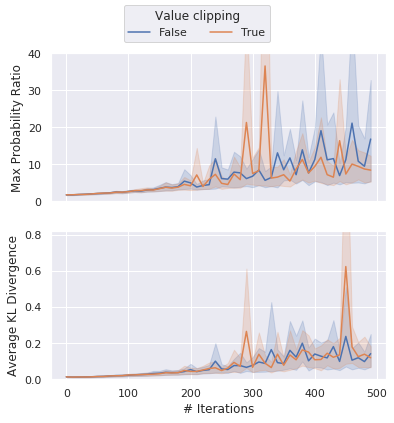

In [65]:
# Plot setup
fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex=True)

for j, m in enumerate(['max_ratio', 'avg_kl_new_to_old']):
    cl_opt = 'value_clipping'
    for b in code_level_opts[cl_opt]:
        filt = constraints_heldout[(constraints_heldout[cl_opt] == b)]
        sns.lineplot(filt.opt_step, filt[m],
                     ax=ax.flatten()[j], label=b, legend=False)
    #ax.flatten()[j].set_title(m)
        
for a in ax.flatten():
    a.set_ylabel('')
    a.set_xlabel('')
ax[0].set_ylabel('Max Probability Ratio')
ax[1].set_ylabel('Average KL Divergence')
ax[1].set_xlabel('# Iterations')
ax[0].set_ylim([0,40])
ax[1].set_ylim([0,0.82])
    
handles, labels = ax[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', title='Value clipping', ncol=2)

plt.show()

In [49]:
tmp = constraints_heldout.copy()
tmp['reward_shaping'] = tmp.apply(
    lambda x:'Reward scaling: %s, reward clipping: %s' % (x['norm_rewards'],(x['clip_rewards'] < 1e8)),axis=1)
tmp = tmp.sort_values('clip_rewards').sort_values('norm_rewards')

No handles with labels found to put in legend.
No handles with labels found to put in legend.


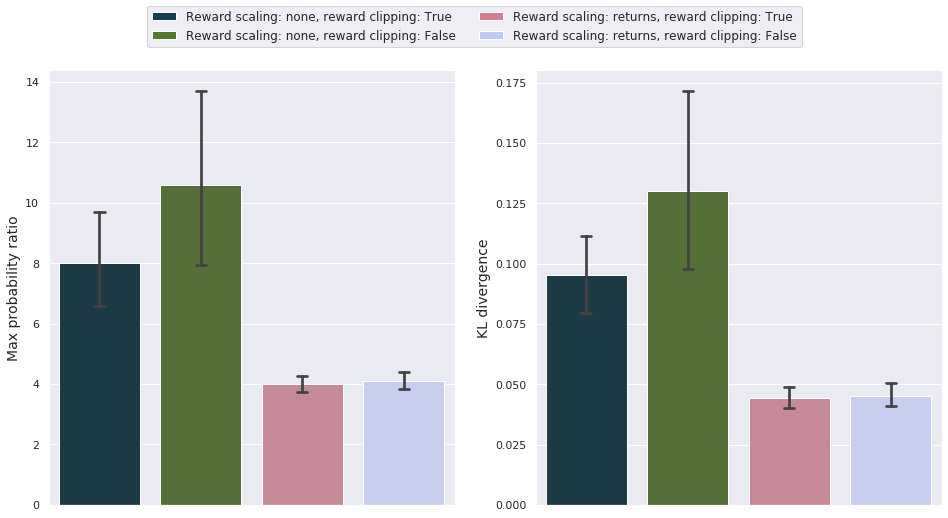

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex='all', sharey='none')
palette = sns.color_palette("cubehelix", 4)
for j, metric in enumerate(['max_ratio', 'avg_kl_new_to_old']):
    ax = axes.flatten()[j]
    b = sns.barplot(x='reward_shaping', y=metric,
                    data=tmp, palette=palette,
                    ax=ax, capsize=.1)
    ax.set_xlabel('')
    ax.set_ylabel(metric, fontsize=14)

#axes[0].set_ylim([0, 5])
#axes[1].set_ylim([0, 0.3])
axes[0].set_ylabel('Max probability ratio')
axes[1].set_ylabel('KL divergence')


from matplotlib.patches import Patch
legend_elements = []
labels = [t.get_text() for t in axes[-1].get_xticklabels()]
for i, label in enumerate(labels):
    legend_elements.append(Patch(facecolor=palette[i], label=label))

for ax in axes:
    ax.set_xticklabels([])
    
fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12)

plt.show()

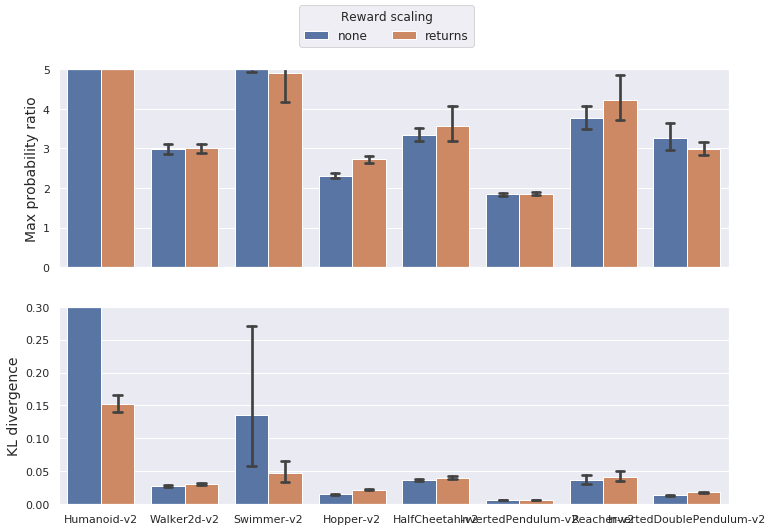

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex='all', sharey='none')
for j, metric in enumerate(['max_ratio', 'avg_kl_new_to_old']):
    ax = axes.flatten()[j]
    b = sns.barplot(x='game', y=metric,
                    data=constraints_heldout, hue='norm_rewards',
                    ax=ax, capsize=.1)
    ax.set_xlabel('')
    ax.set_ylabel(metric, fontsize=14)
    ax.legend().remove()
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', title='Reward scaling', ncol=4, fontsize=12)

axes[0].set_ylim([0, 5])
axes[1].set_ylim([0, 0.3])
axes[0].set_ylabel('Max probability ratio')
axes[1].set_ylabel('KL divergence')

plt.show()

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex='all', sharey='none')
for j, metric in enumerate(['max_ratio', 'avg_kl_new_to_old']):
    ax = axes.flatten()[j]
    b = sns.barplot(x='game', y=metric,
                    data=constraints_heldout, hue='norm_rewards',
                    ax=ax, capsize=.1)
    ax.set_xlabel('')
    ax.set_ylabel(metric, fontsize=14)
    ax.legend().remove()
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', title='Reward scaling', ncol=4, fontsize=12)

axes[0].set_ylim([0, 5])
axes[1].set_ylim([0, 0.3])
axes[0].set_ylabel('Max probability ratio')
axes[1].set_ylabel('KL divergence')

plt.show()

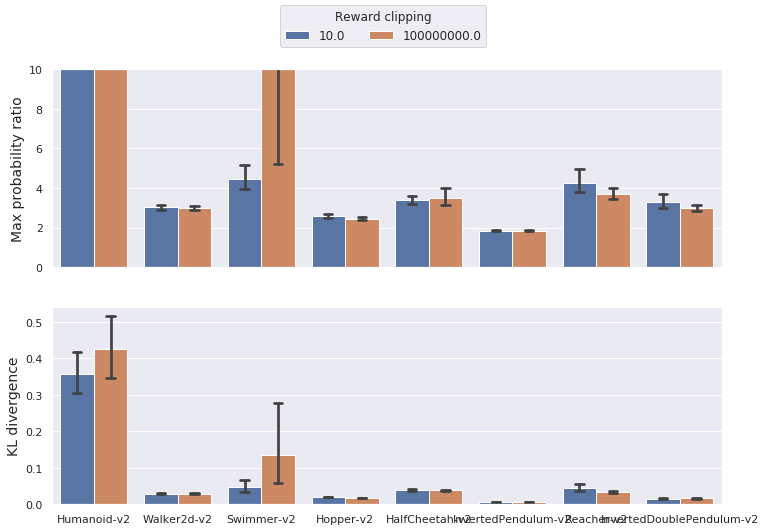

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex='all', sharey='none')
for j, metric in enumerate(['max_ratio', 'avg_kl_new_to_old']):
    ax = axes.flatten()[j]
    b = sns.barplot(x='game', y=metric,
                    data=constraints_heldout, hue='clip_rewards',
                    ax=ax, capsize=.1)
    ax.set_xlabel('')
    ax.set_ylabel(metric, fontsize=14)
    ax.legend().remove()
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', title='Reward clipping', ncol=4, fontsize=12)

axes[0].set_ylim([0, 10])
axes[0].set_ylabel('Max probability ratio')
axes[1].set_ylabel('KL divergence')

plt.show()

In [9]:
exp_id_lookup = key_metadata.groupby(
    ['game', 'value_clipping'])['exp_id'].apply(list)

/home/eecs/chloehsu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eecs/chloehsu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eecs/chloehsu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/eecs/chloehsu/.local/lib/python3.6/site-packages/tensorflow/pyth

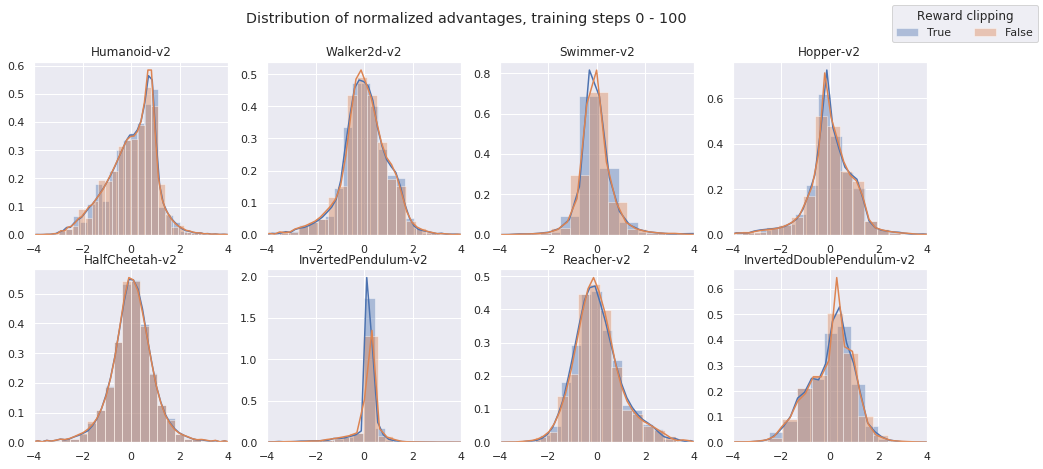

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(16, 7))
ax_idx = 0
for game in key_metadata.game.unique():
    ax = axes.flatten()[ax_idx]
    ax_idx += 1
    for rw in key_metadata.value_clipping.unique():
        show_histogram(exp_id_lookup[game][rw], ax, label=rw, min_step=0, max_step=100)
    ax.set_title(game)
    ax.set_xlim([-4, 4])
    ax.legend()
    ax.get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.suptitle('Distribution of normalized advantages, training steps 0 - 100')
fig.legend(handles, labels, loc='upper right', title='Reward clipping', ncol=3)
plt.show()

AttributeError: 'NoneType' object has no attribute 'remove'

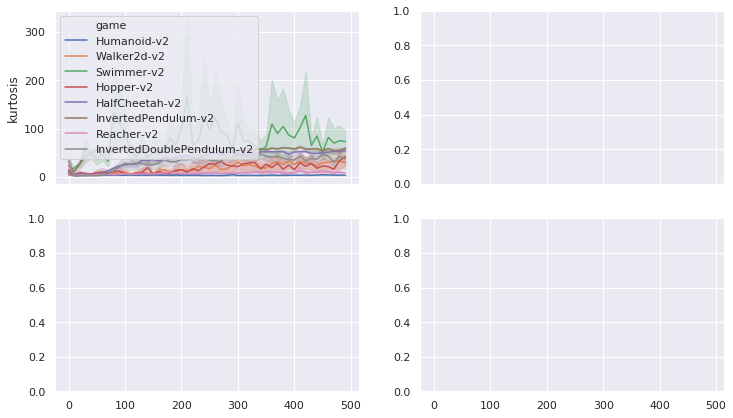

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex='all', sharey=False)

for j, metric in enumerate(nadv_metrics):
    sns.lineplot(x='opt_step', y=metric, hue='game', data=nadv, ax=axes.flatten()[j])
    ax.get_legend().remove()
handles, labels = axes[-1][-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
plt.show()

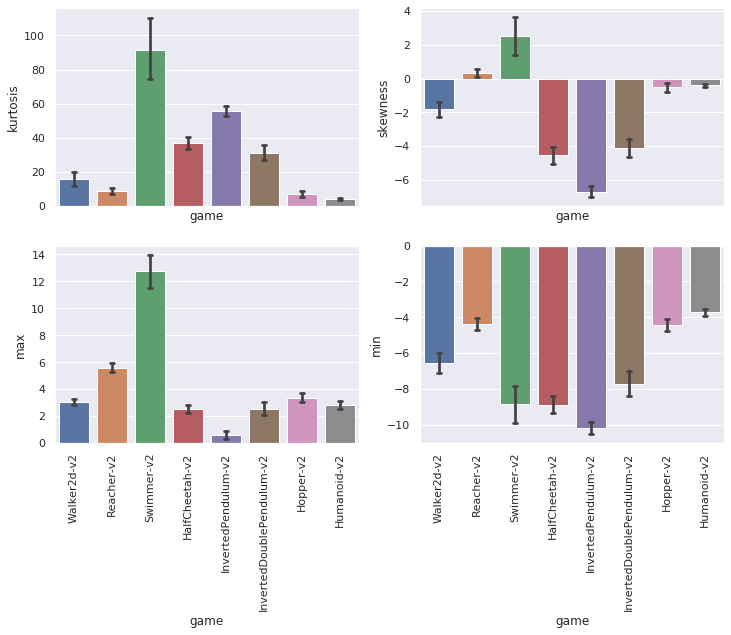

In [42]:

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='all', sharey='none')
for j, metric in enumerate(nadv_metrics):
    b = sns.barplot(x='game', y=metric, data=nadv, ax=axes.flatten()[j], capsize=.1)
    for item in b.get_xticklabels():
        item.set_rotation(90)
    #axes.flatten()[j].get_legend().remove()
#handles, labels = axes[-1][-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center', ncol=1, title='clipped_surrogate')
plt.show()